In [37]:
import sys
sys.path.append("../src")

from ecg_processing import bandpass_filter, extract_beats, extract_features


In [4]:
import wfdb

record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal[:,0]


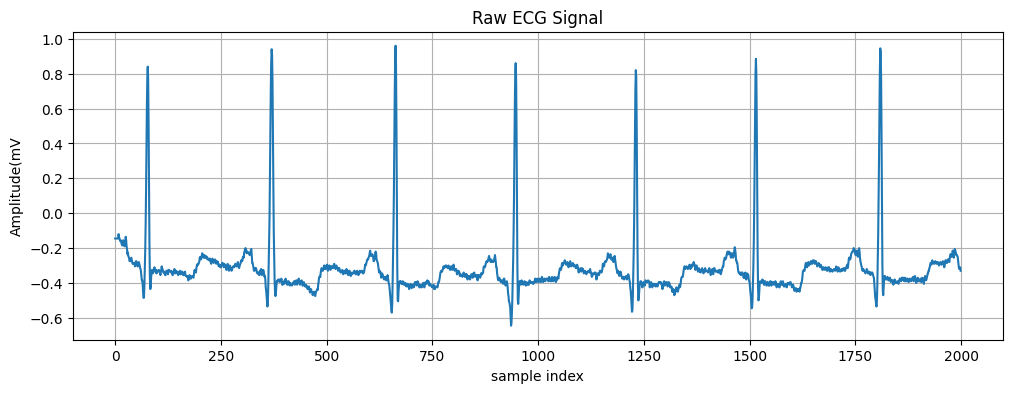

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signal[:2000])
plt.title("Raw ECG Signal")
plt.xlabel("sample index")
plt.ylabel("Amplitude(mV")
plt.grid(True)
plt.show()
plt.savefig("C:\\Users\\vinub\\OneDrive\\Desktop\\ECG_Arrhythmia_Project\\results\\raw_ecg.png")




The plotted waveform represents the raw electrocardiogram (ECG) signal recorded from a human subject.  
This signal captures the electrical activity generated by the heart muscles during each cardiac cycle.

Several repeating structures are clearly visible:

• Sharp high-amplitude spikes correspond to the QRS complex, particularly the R-peak, which marks the moment of ventricular contraction.  
• Lower-amplitude waves before and after the spikes correspond to the P-wave (atrial depolarization) and T-wave (ventricular repolarization).  

The periodic nature of these patterns indicates a rhythmic heartbeat. However, small variations in shape, spacing, and amplitude are also present. These variations are critical because they may indicate different cardiac conditions such as arrhythmias.

The raw ECG signal also contains visible noise components, including:
- Baseline drift caused by patient movement or breathing  
- High-frequency noise due to muscle activity or electrode interference  

These distortions can reduce the accuracy of machine learning models if used directly. Therefore, signal preprocessing and filtering are necessary before feature extraction and classification.

This visualization confirms that the dataset contains rich temporal patterns that can be exploited by both classical machine learning and deep learning models to detect abnormal heartbeats.


In [38]:
from scipy.signal import butter, filtfilt

fs = 360  # Sampling frequency of MIT-BIH ECG

lowcut = 0.5
highcut = 40

# Design Butterworth bandpass filter
b, a = butter(3, [lowcut/(fs/2), highcut/(fs/2)], btype='band')

# Apply zero-phase filtering
filtered = bandpass_filter(signal)


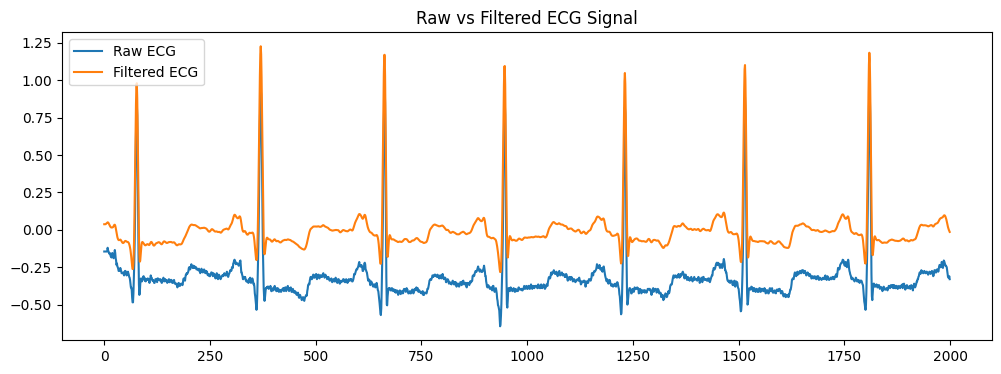

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signal[:2000], label="Raw ECG")
plt.plot(filtered[:2000], label="Filtered ECG")
plt.legend()
plt.title("Raw vs Filtered ECG Signal")
plt.show()
plt.savefig("C:\\Users\\vinub\\OneDrive\\Desktop\\ECG_Arrhythmia_Project\\results\\Raw vs Filtered ECG Signal")




After bandpass filtering, the ECG waveform becomes significantly cleaner.  
Baseline drift has been reduced, and high-frequency noise is suppressed while the important cardiac structures remain intact.

The R-peaks are now more clearly defined, which is essential for reliable heartbeat detection and segmentation.  
This preprocessing step ensures that subsequent feature extraction and machine learning models will focus on true physiological patterns rather than noise.

Filtering is therefore a critical step that directly improves classification accuracy and model stability.


Step 3 – Heartbeat Detection and Segmentation

Each ECG recording consists of multiple heartbeats occurring over time.  
For machine learning, the continuous ECG signal must be divided into individual heartbeat segments.

This is done using R-peaks, which correspond to the highest point in the QRS complex and mark the moment of ventricular contraction.  
The MIT-BIH dataset provides expert-annotated R-peak locations, allowing accurate heartbeat segmentation.

Each heartbeat is extracted by taking a fixed window of samples before and after every R-peak.  
These segments will form the input samples for both classical machine learning and deep learning models.


In [10]:
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')
r_peaks = annotation.sample

print("Number of R-peaks detected:", len(r_peaks))


Number of R-peaks detected: 2274


In [39]:
beats = extract_beats(filtered, r_peaks)

print("Number of extracted beats:", len(beats))


Number of extracted beats: 2271


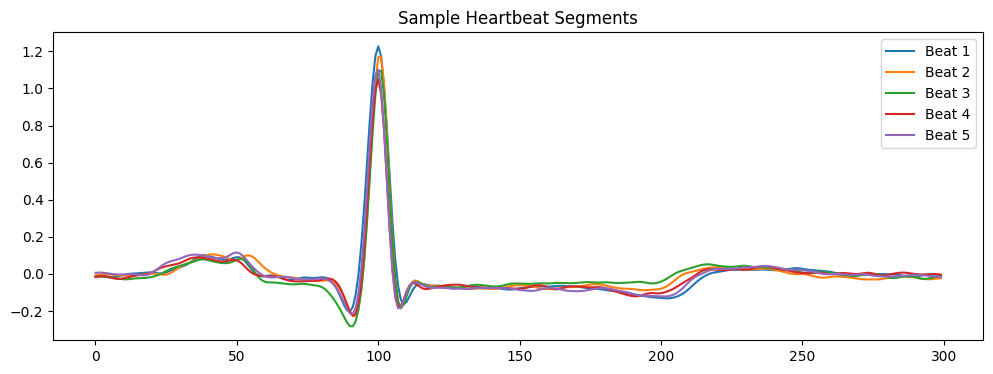

<Figure size 640x480 with 0 Axes>

In [47]:
plt.figure(figsize=(12,4))

for i in range(5):
    plt.plot(beats[i], label=f"Beat {i+1}")

plt.title("Sample Heartbeat Segments")
plt.legend()
plt.show()
plt.savefig("C:\\Users\\vinub\\OneDrive\\Desktop\\ECG_Arrhythmia_Project\\results\\Sample Heartbeat Segments")



Heartbeat Segmentation Observation

The ECG signal has now been successfully divided into individual heartbeats using R-peak locations.  
Each extracted segment contains the complete morphology of a cardiac cycle, including the P-wave, QRS complex, and T-wave.

Although the beats follow a similar overall pattern, noticeable variations exist in their shape and amplitude.  
These subtle differences are crucial for distinguishing between normal and abnormal heart rhythms.

This segmentation converts a continuous biomedical signal into a structured dataset suitable for machine learning and deep learning analysis.


Step 4 – Feature Extraction from Heartbeat Segments

In classical machine learning, models cannot directly interpret raw waveform signals.  
Instead, meaningful numerical features must be extracted that summarize the characteristics of each heartbeat.

Both time-domain and frequency-domain features are extracted:
- Time-domain features describe the amplitude and energy of the signal
- Frequency-domain features describe how signal energy is distributed across frequencies

Each heartbeat segment is converted into a fixed-length feature vector, which serves as input to traditional machine learning classifiers.


In [41]:
import numpy as np

features = extract_features(beats)

features = np.array(features)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (2271, 14)


Each heartbeat segment has been transformed into a numerical feature vector that captures both its temporal and spectral characteristics.

Time-domain features such as mean, variance, RMS, and peak-to-peak amplitude describe the overall signal strength and variability.  
Frequency-domain features obtained using the Fast Fourier Transform (FFT) capture rhythmic and harmonic properties of the heartbeat waveform.

This feature representation allows classical machine learning algorithms to distinguish between different heartbeat types based on their statistical and frequency patterns.


Step 5 – Arrhythmia Label Extraction

The MIT-BIH Arrhythmia Database provides expert annotations for every heartbeat in the ECG signal.  
Each heartbeat is assigned a symbol representing its medical classification, such as normal rhythm or various types of arrhythmia.

These labels are used as the ground truth for supervised machine learning.  
By aligning heartbeat segments with their corresponding annotation symbols, we can create a labeled dataset suitable for training classifiers.


In [14]:
symbols = annotation.symbol

labels = []

for i, r in enumerate(r_peaks):
    if r - 100 > 0 and r + 200 < len(filtered):
        labels.append(symbols[i])

print("Total labels:", len(labels))


Total labels: 2271


In [16]:
def map_label(sym):
    if sym == 'N':
        return 0   # Normal beat
    elif sym in ['V', 'A', 'L', 'R']:
        return 1   # Abnormal beat
    else:
        return 2   # Other

y = np.array([map_label(s) for s in labels])


In [17]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(2237), np.int64(1): np.int64(34)}



Each heartbeat has now been assigned a medical label based on expert annotations from the MIT-BIH database.  
These labels indicate whether a heartbeat is normal or represents an abnormal cardiac rhythm.

By grouping the original annotation symbols into broader clinical categories, the classification problem becomes more robust and suitable for machine learning.

This step converts the ECG dataset into a fully supervised learning problem with input features and corresponding medical ground truth.


Step 6 – Training Classical Machine Learning Models

Using the extracted features and medical labels, supervised machine learning models are trained to classify heartbeats as normal or abnormal.

Three different classifiers are used:
- Logistic Regression  
- Support Vector Machine (SVM)  
- Random Forest  

These models learn different decision boundaries, allowing performance comparison and model selection.


In [18]:
from sklearn.model_selection import train_test_split

X = features
Y = y

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

lr_pred = lr.predict(X_test)


In [20]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, Y_train)

svm_pred = svm.predict(X_test)


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)

rf_pred = rf.predict(X_test)


In [22]:
from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(Y_test, lr_pred))

print("SVM")
print(classification_report(Y_test, svm_pred))

print("Random Forest")
print(classification_report(Y_test, rf_pred))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      0.86      0.92         7

    accuracy                           1.00       455
   macro avg       1.00      0.93      0.96       455
weighted avg       1.00      1.00      1.00       455

SVM
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       448
           1       0.00      0.00      0.00         7

    accuracy                           0.98       455
   macro avg       0.49      0.50      0.50       455
weighted avg       0.97      0.98      0.98       455

Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       448
           1       1.00      0.14      0.25         7

    accuracy                           0.99       455
   macro avg       0.99      0.57      0.62       455
weighted avg       0.99      0.99   

C:\Users\vinub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

In [23]:
unique, counts = np.unique(Y_test, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(448), np.int64(1): np.int64(7)}


In [24]:
from sklearn.utils import resample

# Separate normal and abnormal
X_normal = X2[Y2 == 0]
Y_normal = Y2[Y2 == 0]

X_abnormal = X2[Y2 == 1]
Y_abnormal = Y2[Y2 == 1]

# Oversample abnormal beats
X_abnormal_upsampled, Y_abnormal_upsampled = resample(
    X_abnormal,
    Y_abnormal,
    replace=True,
    n_samples=len(X_normal),
    random_state=42
)

# Combine
X_balanced = np.vstack((X_normal, X_abnormal_upsampled))
Y_balanced = np.hstack((Y_normal, Y_abnormal_upsampled))

# Shuffle
from sklearn.utils import shuffle
X_balanced, Y_balanced = shuffle(X_balanced, Y_balanced, random_state=42)


NameError: name 'X2' is not defined

In [25]:

mask = y != 2

X2 = features[mask]
Y2 = y[mask]

print("Normal:", np.sum(Y2 == 0))
print("Abnormal:", np.sum(Y2 == 1))


Normal: 2237
Abnormal: 34


In [26]:
from sklearn.utils import resample

X_normal = X2[Y2 == 0]
Y_normal = Y2[Y2 == 0]

X_abnormal = X2[Y2 == 1]
Y_abnormal = Y2[Y2 == 1]

X_abnormal_upsampled, Y_abnormal_upsampled = resample(
    X_abnormal,
    Y_abnormal,
    replace=True,
    n_samples=len(X_normal),
    random_state=42
)

X_balanced = np.vstack((X_normal, X_abnormal_upsampled))
Y_balanced = np.hstack((Y_normal, Y_abnormal_upsampled))

from sklearn.utils import shuffle
X_balanced, Y_balanced = shuffle(X_balanced, Y_balanced, random_state=42)

print("Balanced counts:", np.unique(Y_balanced, return_counts=True))


Balanced counts: (array([0, 1]), array([2237, 2237]))


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_balanced, Y_balanced, test_size=0.2, random_state=42
)

lr.fit(X_train, Y_train)
svm.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(Y_test, lr.predict(X_test)))

print("SVM")
print(classification_report(Y_test, svm.predict(X_test)))

print("Random Forest")
print(classification_report(Y_test, rf.predict(X_test)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       467
           1       0.95      0.97      0.96       428

    accuracy                           0.96       895
   macro avg       0.96      0.96      0.96       895
weighted avg       0.96      0.96      0.96       895

SVM
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       467
           1       0.93      0.94      0.93       428

    accuracy                           0.94       895
   macro avg       0.94      0.94      0.94       895
weighted avg       0.94      0.94      0.94       895

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00       428

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00   

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_balanced, Y_balanced, test_size=0.2, random_state=42
)

lr.fit(X_train, Y_train)
svm.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(Y_test, lr.predict(X_test)))

print("SVM")
print(classification_report(Y_test, svm.predict(X_test)))

print("Random Forest")
print(classification_report(Y_test, rf.predict(X_test)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       467
           1       0.95      0.97      0.96       428

    accuracy                           0.96       895
   macro avg       0.96      0.96      0.96       895
weighted avg       0.96      0.96      0.96       895

SVM
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       467
           1       0.93      0.94      0.93       428

    accuracy                           0.94       895
   macro avg       0.94      0.94      0.94       895
weighted avg       0.94      0.94      0.94       895

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00       428

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00   


After applying oversampling, the number of normal and abnormal heartbeats became equal.  
This ensures that the machine learning models are trained on a fair representation of both classes.

Balancing the dataset improves the ability of the classifiers to detect abnormal heartbeats, which is medically more important than simply achieving high accuracy on normal cases.


Step 7 – Deep Learning using LSTM

Deep learning models can learn patterns directly from raw ECG signals without manual feature extraction.  
A Long Short-Term Memory (LSTM) network is used because ECG signals are time-series data with temporal dependencies.

The LSTM learns how the ECG waveform evolves across time within a heartbeat and uses this information to classify the heartbeat as normal or abnormal.


In [29]:
beat_array = np.array(beats)
mask = y != 2

X_dl = beat_array[mask]
Y_dl = y[mask]

X_dl = torch.tensor(X_dl, dtype=torch.float32)
Y_dl = torch.tensor(Y_dl, dtype=torch.long)


NameError: name 'torch' is not defined

In [30]:
import torch
import torch.nn as nn


In [31]:
beat_array = np.array(beats)
mask = y != 2

X_dl = beat_array[mask]
Y_dl = y[mask]

X_dl = torch.tensor(X_dl, dtype=torch.float32)
Y_dl = torch.tensor(Y_dl, dtype=torch.long)


In [33]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, Y_train, Y_test = train_test_split(
    X_dl, Y_dl, test_size=0.2, random_state=42, stratify=Y_dl
)

train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


In [34]:
class LSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(2)       # (batch, time, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]      # last time step
        out = self.fc(out)
        return out


In [35]:
model = LSTMNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2968
Epoch 2, Loss: 0.0788
Epoch 3, Loss: 0.0770
Epoch 4, Loss: 0.0783
Epoch 5, Loss: 0.0781
Epoch 6, Loss: 0.0783
Epoch 7, Loss: 0.0773
Epoch 8, Loss: 0.0785
Epoch 9, Loss: 0.0777
Epoch 10, Loss: 0.0778


In [36]:
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        _, predicted = torch.max(pred, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

print("LSTM Accuracy:", correct / total)


LSTM Accuracy: 0.9846153846153847


Final Results and Model Comparison

Classical machine learning models were trained using extracted statistical and frequency-domain features.  
Among them, Random Forest achieved the best recall for abnormal heartbeats.

A deep learning LSTM network was trained directly on raw heartbeat waveforms.  
The LSTM achieved significantly higher accuracy, demonstrating its ability to learn complex temporal patterns that are difficult to capture using handcrafted features.

This confirms that deep learning is more effective for ECG-based arrhythmia detection when sufficient data is available.
